In [1]:
import random
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, RepeatVector
import matplotlib.pyplot as plt

/home/cbrom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


** Generate Sum Pairs **

In [2]:
# generate lists of random integers and their sum
def random_sum_pairs(n_examples, n_numbers, largest):
    X, y = [], []
    for i in range(n_examples):
        in_pattern = [random.randint(1, largest) for _ in range(n_numbers)]
        out_pattern = sum(in_pattern)
        
        X.append(in_pattern)
        y.append(out_pattern)
    return X, y

In [3]:
random.seed(1)
n_samples = 2
n_numbers = 2
largest = 10

X, y = random_sum_pairs(n_samples, n_numbers, largest)
print(X, y)

[[3, 10], [2, 5]] [13, 7]


** Integers to Padded Strings **

In [4]:
# pad and convert data to strings
def to_string(X, y, n_numbers, largest):
    max_length = int(n_numbers * np.ceil(np.log10(largest+1)) + n_numbers - 1)
    Xstr = []
    for pattern in X:
        strp = '+'.join([str(n) for n in pattern])
        strp = ''.join([' ' for _ in range(max_length-len(strp))]) + strp
        Xstr.append(strp)
    
    max_length = int(np.ceil(np.log10(n_numbers * (largest + 1))))
    ystr = []
    
    for pattern in y:
        strp = str(pattern)
        strp = ''.join([' ' for _ in range(max_length - len(strp))]) + strp
        ystr.append(strp)
    return Xstr, ystr


In [5]:
# generate pairs
X, y = random_sum_pairs(n_samples, n_numbers, largest)
print(X, y)
# convert to strings
X, y = to_string(X, y, n_numbers, largest)
print(X, y)

[[2, 8], [8, 8]] [10, 16]
['  2+8', '  8+8'] ['10', '16']


** Integer Encoded Sequences **

In [6]:
# integer encode strings
def integer_encode(X, y, alphabet):
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    Xenc = []
    for pattern in X:
        integer_encoded = [char_to_int[char] for char in pattern]
        Xenc.append(integer_encoded)
    
    yenc = []
    for pattern in y:
        integer_encoded = [char_to_int[char] for char in pattern]
        yenc.append(integer_encoded)
    return Xenc, yenc

In [7]:
# generate pairs
X, y = random_sum_pairs(n_samples, n_numbers, largest)
print(X, y)
X, y = to_string(X, y, n_numbers, largest)
print(X, y)

# integer encode
alphabet = list('1234567890 +')
X, y = integer_encode(X, y, alphabet)
print(X, y)

[[7, 4], [2, 8]] [11, 10]
['  7+4', '  2+8'] ['11', '10']
[[10, 10, 6, 11, 3], [10, 10, 1, 11, 7]] [[0, 0], [0, 9]]


** One Hot Encoded Sequences **

In [8]:
index_values = np.array(range(len(alphabet))).reshape(-1, 1)
encoder = OneHotEncoder(sparse=False).fit(index_values)

def one_hot_encode(X, y):
    Xenc = np.array([encoder.transform(np.array(vector).reshape(len(vector), 1)) for vector in X])
    yenc = np.array([encoder.transform(np.array(vector).reshape(len(vector), 1)) for vector in y])
    return Xenc, yenc

In [9]:
# generate pairs
X, y = random_sum_pairs(n_samples, n_numbers, largest)
print(X, y)
X, y = to_string(X, y, n_numbers, largest)
print(X, y)

# integer encode
alphabet = list('1234567890 +')
X, y = integer_encode(X, y, alphabet)
print(X, y)

# one hot encode
X, y = one_hot_encode(X, y)
print(X, y)

[[1, 7], [7, 10]] [8, 17]
['  1+7', ' 7+10'] [' 8', '17']
[[10, 10, 0, 11, 6], [10, 6, 11, 0, 9]] [[10, 7], [0, 6]]
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]] [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]]


** Sequence Generation Pipeline **

In [10]:
# generate an encoded dataset
def generate_data(n_samples, n_numbers, largest, alphabet):
    # generate pairs
    X, y = random_sum_pairs(n_samples, n_numbers, largest)
    # convert to strings
    X, y = to_string(X, y, n_numbers, largest)
    # integer encode
    X, y = integer_encode(X, y, alphabet)
    # one hot encode
    X, y = one_hot_encode(X, y)
    
    return X, y

** Decode Sequences **

In [11]:
# inbert encoding
def invert(seq, alphabet):
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    strings = ''.join([int_to_char[np.argmax(vector)] for vector in seq])
    return strings

** Define and Compile the Model **

In [12]:
# number of math terms
n_terms = 3
# largest value for any single input digit
largest = 10
# scope of possible symbols for each input or output time step
alphabet = list('0123456789 +')

# size of alphabet
n_chars = len(alphabet)
# length of input sequence
n_in_seq_length = int(n_terms * np.ceil(np.log10(largest+1)) + n_terms - 1)
# length of encoded output sequence
n_out_seq_length = int(np.ceil(np.log10(n_terms * (largest+1))))

In [13]:
# define LSTM model
model = Sequential()
model.add(LSTM(75, input_shape=(n_in_seq_length, n_chars)))
model.add(RepeatVector(n_out_seq_length))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(n_chars, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 75)                26400     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 75)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 50)             25200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 12)             612       
Total params: 52,212
Trainable params: 52,212
Non-trainable params: 0
_________________________________________________________________
None


** Fit the Model **

In [14]:
# fit LSTM
X, y = generate_data(75000, n_terms, largest, alphabet)
model.fit(X, y, epochs=1, batch_size=32)

Epoch 1/1
75000/75000 [==============================] - 14s 183us/step - loss: 0.7145 - acc: 0.7864


** Evaluate the Model **

In [15]:
# evaluate LSTM
X, y = generate_data(100, n_terms, largest, alphabet)
loss, acc =  model.evaluate(X, y, verbose=0)
print('Loss: %f, Accuracy: %f' % (loss, acc * 100))

Loss: 0.158595, Accuracy: 96.500000


** Make Predictions with the Model **

In [16]:
# predict
for _ in range(10):
    # generate an input_output pair
    X, y = generate_data(1, n_terms, largest, alphabet)
    # make prediction
    yhat =  model.predict(X, verbose=0)
    #decode input, expected and predicted
    in_seq = invert(X[0], alphabet)
    out_seq = invert(y[0], alphabet)
    predicted = invert(yhat[0], alphabet)
    print('%s = %s  (expect %s)' % (in_seq, predicted, out_seq))

 10+7+10 = 27  (expect 27)
  10+2+3 = 15  (expect 15)
   8+4+1 = 13  (expect 13)
   8+1+3 = 12  (expect 12)
   5+9+6 = 20  (expect 20)
   1+5+8 = 14  (expect 14)
   2+2+6 = 10  (expect 10)
  9+5+10 = 24  (expect 24)
   6+5+7 = 18  (expect 18)
   9+1+7 = 17  (expect 17)


---------------------------

** Diagnostics **

In [17]:
# define LSTM model
model = Sequential()
model.add(LSTM(75, input_shape=(n_in_seq_length, n_chars)))
model.add(RepeatVector(n_out_seq_length))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(n_chars, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 75)                26400     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 2, 75)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 2, 50)             25200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 2, 12)             612       
Total params: 52,212
Trainable params: 52,212
Non-trainable params: 0
_________________________________________________________________
None


** Saving History **

In [18]:
# fit LSTM
X, y = generate_data(75000, n_terms, largest, alphabet)
X_val, y_val = generate_data(15000, n_terms, largest, alphabet)
history = model.fit(X, y, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Train on 75000 samples, validate on 15000 samples
Epoch 1/10
75000/75000 [==============================] - 14s 193us/step - loss: 0.7063 - acc: 0.7939 - val_loss: 0.4019 - val_acc: 0.8082
Epoch 2/10
75000/75000 [==============================] - 13s 178us/step - loss: 0.0964 - acc: 0.9834 - val_loss: 0.0409 - val_acc: 0.9955
Epoch 3/10
75000/75000 [==============================] - 14s 181us/step - loss: 0.0311 - acc: 0.9934 - val_loss: 0.0142 - val_acc: 0.9984
Epoch 4/10
75000/75000 [==============================] - 14s 181us/step - loss: 0.0098 - acc: 0.9982 - val_loss: 0.0050 - val_acc: 0.9997
Epoch 5/10
75000/75000 [==============================] - 14s 182us/step - loss: 0.0530 - acc: 0.9866 - val_loss: 0.0045 - val_acc: 0.9997
Epoch 6/10
75000/75000 [==============================] - 14s 186us/step - loss: 0.0354 - acc: 0.9938 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 7/10
75000/75000 [==============================] - 14s 193us/step - loss: 0.0031 - acc: 0.9999 - val_loss: 0.

In [19]:
print(history.history['loss'])
print(history.history['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])

[0.7063301603794098, 0.09641556166013082, 0.03114356297691663, 0.009764916904307901, 0.052979240563064814, 0.03539909186994036, 0.0031427390788371363, 0.0009981260487996041, 0.0003264462394407019, 0.00010584432549891062]
[0.7938866666603088, 0.98342, 0.9933933333333334, 0.9982, 0.98662, 0.9937866666666667, 0.99994, 1.0, 1.0, 1.0]
[0.4019025852362315, 0.04087818535864353, 0.014165535678962867, 0.005014348659229775, 0.004505598220229149, 0.006549532649293542, 0.0015992216202119986, 0.0005325785941289117, 0.00017071648782584817, 5.6123859099655724e-05]
[0.8082, 0.9954666666666667, 0.9983666666666666, 0.9996666666666667, 0.9996666666666667, 1.0, 1.0, 1.0, 1.0, 1.0]


** Diagnostic plot **

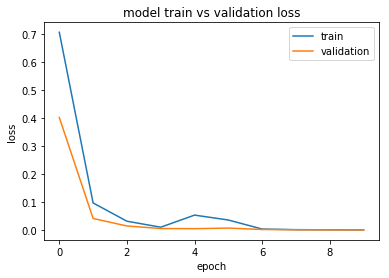

In [20]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

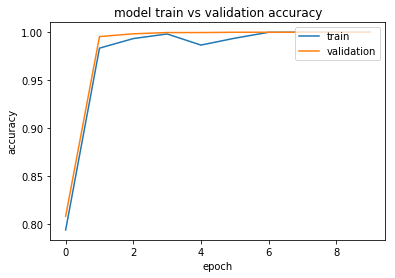

In [21]:
# accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

** Evaluate the Model **

In [22]:
# evaluate LSTM
X, y = generate_data(100, n_terms, largest, alphabet)
loss, acc =  model.evaluate(X, y, verbose=0)
print('Loss: %f, Accuracy: %f' % (loss, acc * 100))

Loss: 0.000042, Accuracy: 100.000000


** Make Predictions with the Model **

In [23]:
# predict
for _ in range(10):
    # generate an input_output pair
    X, y = generate_data(1, n_terms, largest, alphabet)
    # make prediction
    yhat =  model.predict(X, verbose=0)
    #decode input, expected and predicted
    in_seq = invert(X[0], alphabet)
    out_seq = invert(y[0], alphabet)
    predicted = invert(yhat[0], alphabet)
    print('%s = %s  (expect %s)' % (in_seq, predicted, out_seq))

  9+3+10 = 22  (expect 22)
  10+2+6 = 18  (expect 18)
   6+3+9 = 18  (expect 18)
   2+9+9 = 20  (expect 20)
   8+5+8 = 21  (expect 21)
   8+6+8 = 22  (expect 22)
   7+2+3 = 12  (expect 12)
   7+7+7 = 21  (expect 21)
  10+4+7 = 21  (expect 21)
   8+8+2 = 18  (expect 18)


In [24]:
with_proba = model.predict_proba(X)

In [25]:
print(with_proba)
print(np.argmax(with_proba[0][0]))
print(np.argmax(with_proba[0][1]))

[[[1.1697482e-10 1.0000000e+00 1.9828652e-09 5.2643838e-13 4.3887038e-16
   5.4706268e-17 6.3983552e-15 1.3322683e-10 5.8937417e-12 2.5548504e-12
   2.0749778e-14 1.9720957e-14]
  [3.1924526e-07 1.6846965e-09 1.1741245e-12 2.1705736e-10 5.6293761e-09
   2.0757932e-08 1.4569605e-05 3.4228666e-05 9.9992633e-01 2.4612307e-05
   5.9593108e-11 1.2992354e-09]]]
1
8


In [26]:
model.predict_classes(X)

array([[1, 8]])

In [27]:
model.save("lesson 13.h5")